## Figure pool and profiles

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
import matplotlib.patches as pat
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.metrics_tools as mpt
import canyon_tools.savitzky_golay as sg

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, sbdepth)
    return(bathyMasked.mask)

def BottomConc(Tr, hfac, ra, bathy, nz, sbdepth=-152.5):
    '''Tr: Tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcArea = concentration at cell closest to bottom times its area (nt,ny,nx)
       Conc = cocnetration near bottom (nt,ny,nx)'''
    
    ConcArea = np.empty((360,616))
    Conc = np.empty((360,616))
    ConcFiltered = np.empty((360,616))
    Area = np.empty((360,616))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = (np.ones(np.shape(BottomInd))*nz - BottomInd) # Get index of unreversed z axis
    
    for j in range(616):
        for i in range(360):
            TrBottom = Tr[int(BottomInd[i,j]),i,j]
            ConcArea[i,j] = TrBottom*ra[i,j]
            Conc[i,j] = TrBottom
            Area[i,j] = ra[i,j]
                    
        # Filter step noise
        ConcFiltered[:,j] = sg.savitzky_golay(Conc[:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (ConcArea,
            np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area,
           )

def getProfile(ptracers_file, mask, trac, xind, yind, zslice, tt):
    
    with Dataset(ptracers_file, 'r') as nbl:
        
        tr = np.ma.masked_array(nbl.variables[trac][tt,zslice,yind,xind], mask = mask[zslice,yind,xind])
       
    return (tr)

def getMeanProfile(ptracers_file, mask, trac, xind, yind, zslice, tslice):
    
    with Dataset(ptracers_file, 'r') as nbl:
         tr = np.ma.masked_array(np.nanmean(nbl.variables[trac][tslice,zslice,yind,xind],axis=0),
                                 mask = mask[zslice,yind,xind])
       
    return (tr)

def PlotPool(ax,ConcFilt,X,Y,xslice,yslice,colmap, cmin=0.2, cmax=1.8):
    
    BAC = ConcFilt[yslice,xslice]
    levels = np.linspace(cmin,cmax,20) #[0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8]
    mesh = ax.contourf(X[xslice]/1000,Y[yslice]/1000,BAC,levels,
                       vmin=cmin, vmax=cmax, cmap=colmap, 
                      )
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[0.2,1.0],colors='k')
    plt.clabel(cs, fmt='%1.1f', fontsize=10)
    
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)
    ax.set_aspect(1)
    return(mesh)

def PlotBdy(ax,ConcFilt,X,Y,xslice,yslice,color):
    
    BAC = ConcFilt[yslice,xslice]
    
    cs = ax.contour(X[xslice]/1000,Y[yslice]/1000,BAC,[1.0],colors=color)
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)   
                       
    ax.set_aspect(1)
    return(cs)

def PlotPoolsTr(ax1,tslice, key, ptr_fileA, 
                xslice_pl, yslice_pl, nz,
                hFacA, rAA, DepthA, XA, YA,sbind,
                sbdepthA=-150,colmap=cmo.cm.delta, pool_min=0.2, pool_max=1.8):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotPool(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                         xslice_pl,yslice_pl, colmap, cmin=pool_min, cmax=pool_max)

    ax1.set_facecolor("darkgrey")
    ax1.set_aspect(1)
    return(ax1, mesh1)

def PlotPoolBoundary(ax1, tslice, key, ptr_fileA, 
                     xslice_pl, yslice_pl, nz,
                     hFacA, rAA, DepthA, XA, YA,sbind,color,
                     sbdepthA=-150):
    
    sns.set_style('white')
    with Dataset(ptr_fileA, 'r') as nbl:
        ConcAreaLinA, ConcLinA, AreaTrA = BottomConc(np.nanmean(nbl.variables[key][tslice,:,:,:], axis=0),
                                                     hFacA,rAA,DepthA, nz-1,sbdepth=sbdepthA)
        mesh1 = PlotBdy(ax1,ConcLinA/nbl.variables[key][0,sbind,50,50],XA, YA,
                        xslice_pl,yslice_pl,color)

    ax1.set_aspect(1)
    return(ax1)

def plot_pool_profiles(ax0,ax1,ax2,ax3,ptr_file,maskC, ptr_fileNoC,maskCNoC, key, units,
                       zslice,Z, yind, xind, sbind, Csb, depths):
    
    pal1 = sns.color_palette('Blues', 10)
    
    for ii,ax,st in zip(range(4),[ax0,ax1,ax2,ax3],['S1','S2','S3','S4']):
        ax.axvline(1, color='0.8', linewidth=1)
        ax.set_xlabel('$C/C_s$', labelpad=0)
        ax.set_ylim(0,-Z[sbind])
        ax.text(0.05,0.05,st,transform=ax.transAxes, fontsize=10) 
    
    for ii,ax in zip(range(4),[ax0,ax1,ax2,ax3]):
        for tt in range(0,19,4):
            tr = getProfile(ptr_file, maskC, key, xind[ii], yind[ii], zslice, tt)
            depth_bot = depths[yind[ii], xind[ii]]
            ax.plot(tr/Csb, Z[zslice]-depth_bot,color=pal1[int(tt/2)], label='%d d' %(tt/2))
            ax.tick_params(axis='x', pad=1)
            ax.tick_params(axis='y', pad=1)   
           
            
    ax0.set_ylabel('Height above bottom / m', labelpad=0)
    
    return(ax3) 
 
def plot_profiles_advPh(ax, ptr_file,maskC, ptr_fileNoC, maskCNoC,key,color,Csb,lines,st_names,
                        zslice,tslice, Z, yind, xind, sbind, depths, min_dC=-20):
    
    ax.axvline(0, color='0.8', linewidth=1)
    ax.set_xlabel(r'$\Delta C/C_s$', labelpad=0)
    ax.set_ylim(0,-Z[sbind])
    
    for ii, line, station_name in zip(range(len(yind)), lines, st_names):   
        tr = getMeanProfile(ptr_file, maskC, key, xind[ii], yind[ii], zslice, tslice)
        tr0 = getProfile(ptr_file, maskC, key, xind[ii], yind[ii], zslice, 0)
        depth_bot = depths[yind[ii], xind[ii]]
        ax.plot((tr-tr0)/Csb, Z[zslice]-depth_bot, color=color, label=station_name, linestyle=line)
        
    ax.tick_params(axis='x', pad=1)
    ax.tick_params(axis='y', pad=1)       
    
    return(ax) 
 

In [12]:
tracers = ['Tr01','Tr03','Tr04','Tr08','Tr09']
colours = ['#332288','#117733','#999933','#AA4499', 'dimgray']


labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Lin','Oxy','Nit','Met','DIC']
units = ['(muM)m3/s','(umol/kg)m3/s','(muM)m3/s',
         '(nM)m3/s','(umol/kg)m3/s']

In [5]:
ptr_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/ptracersGlob.nc'
grid_fileB = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/01_Bar03/gridGlob.nc'

ptr_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/ptracersGlob.nc'
grid_fileA = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc'

ptr_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/ptracersGlob.nc'
grid_fileBNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF4_BAR/02_Bar03_No_Cny/gridGlob.nc'

ptr_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/ptracersGlob.nc'
grid_fileANoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc'

In [6]:
nz = 104
nt = 19
sb_Ast = 29 # shelf break z-index Astoria
sb_Bar = 39 # shelf break z-index Barkley

with Dataset(grid_fileB, 'r') as nbl:
    ZB = nbl.variables['RC'][:]
    YB = nbl.variables['Y'][:]
    XB = nbl.variables['X'][:]
    hFacB = nbl.variables['HFacC'][:]
    DepthB = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacB, 0)
    maskCB = np.ma.getmask(hfac)
    rAB = nbl.variables['rA'][:]
    
with Dataset(grid_fileA, 'r') as nbl:
    ZA = nbl.variables['RC'][:]
    YA = nbl.variables['Y'][:]
    XA = nbl.variables['X'][:]
    hFacA = nbl.variables['HFacC'][:]
    DepthA = nbl.variables['Depth'][:]
    hfac = np.ma.masked_values(hFacA, 0)
    maskCA = np.ma.getmask(hfac)
    rAA = nbl.variables['rA'][:]
    
with Dataset(grid_fileBNoC, 'r') as nbl:
    hFacBNoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacBNoC, 0)
    maskCBNoC = np.ma.getmask(hfacNoC)
    DepthBNoC = nbl.variables['Depth'][:]
    rABNoC = nbl.variables['rA'][:]
    
with Dataset(grid_fileANoC, 'r') as nbl:
    hFacANoC = nbl.variables['HFacC'][:]
    hfacNoC = np.ma.masked_values(hFacANoC, 0)
    maskCANoC = np.ma.getmask(hfacNoC)
    DepthANoC = nbl.variables['Depth'][:]
    rAANoC = nbl.variables['rA'][:]
    
with Dataset(ptr_fileA, 'r') as nbl:
    time = nbl.variables['T'][:]
    
sb_depthA = ZA[sb_Ast]
sb_depthB = ZB[sb_Bar]


In [10]:
labels_exp = ['Astoria', 'ARGO', 'Barkley', 'Pathways']
labels_tra = ['Linear','Oxygen','Nitrate','Methane','DIC']
units = [r'\muM m$^3$s$^{-1}$',r'$\mu$mol kg$^{-1}m$^3$s$^{-1}$',r'\muM m$^3$s$^{-1}$'
         r'nM m$^3$s$^{-1}$',r'$\mu$mol kg$^{-1}$m$^3$s^{-2}']
factors = [1,1,1,1E-3,1]


In [11]:
sb_conc_A = np.empty(len(labels_tra))
sb_conc_B = np.empty(len(labels_tra))

for ii, trac in zip(range(len(tracers)),tracers):
    for pfile,sb_array, sb_ind in zip([ptr_fileB, ptr_fileA],[sb_conc_A, sb_conc_B], [sb_Ast, sb_Bar]):
        with Dataset(pfile, 'r') as nbl:
            tr_profile = nbl.variables[trac][0,:,10,180]
            sb_array[ii] = tr_profile[sb_ind]

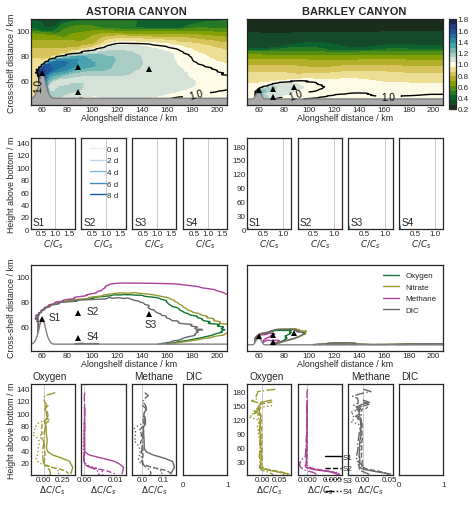

In [19]:
sns.set_style('white')
sns.set_context('paper')
plt.rcParams.update({'font.size': 11})
fig=plt.figure(figsize=(7.4,9))

gs = gspec.GridSpec(2, 2, hspace=0.01,wspace=0.1)

gs0 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,0],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs01 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs0[1],wspace=0.15,width_ratios=[1,1,1,1])

gs1 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0,1],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs11 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs1[1],wspace=0.15,width_ratios=[1,1,1,1])

gs2 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,0],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs21 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs2[1],wspace=0.15,width_ratios=[1,1,1,1])

gs3 = gspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1,1],hspace=0.0,wspace=0.15,height_ratios=[1,0.6])
gs31 = gspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs3[1],wspace=0.15,width_ratios=[1,1,1,1])

ax0 = plt.subplot(gs0[0])
ax1 = plt.subplot(gs01[0])
ax2 = plt.subplot(gs01[1])
ax3 = plt.subplot(gs01[2])
ax3b = plt.subplot(gs01[3])
 
ax4 = plt.subplot(gs1[0])
ax5 = plt.subplot(gs11[0])
ax6 = plt.subplot(gs11[1])
ax7 = plt.subplot(gs11[2])
ax7b = plt.subplot(gs11[3])

ax8 = plt.subplot(gs2[0])
ax9 = plt.subplot(gs21[0])
ax10 = plt.subplot(gs21[1])
ax11= plt.subplot(gs21[2])
ax11b = plt.subplot(gs21[3])

ax12 = plt.subplot(gs3[0])
ax13 = plt.subplot(gs31[0])
ax14 = plt.subplot(gs31[1])
ax15= plt.subplot(gs31[2])
ax15b = plt.subplot(gs31[3])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)
tslice = slice(8,nt)
key = 'Tr01'

# Bottom concetration linear profile (mean during adv. phase)
ax0, mesh0 = PlotPoolsTr(ax0, tslice, key, ptr_fileA, 
                          xslice_pl, yslice_pl, nz,
                          hFacA, rAA, DepthA, XA, YA,sb_Ast,
                          sbdepthA=sb_depthA)
ax0.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],
            [-sb_depthA], colors='0.5')

ax4, mesh4 = PlotPoolsTr(ax4, tslice, key, ptr_fileB, 
                         xslice_pl, yslice_pl, nz,
                         hFacB, rAB, DepthB, XB, YB,sb_Bar,
                         sbdepthA=sb_depthB)
ax4.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],
            [-sb_depthB], colors='0.5')
ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km', labelpad=0)
ax0.set_xlabel('Alongshelf distance / km', labelpad=0)
ax4.set_xlabel('Alongshelf distance / km', labelpad=0)

cbar_ax = fig.add_axes([0.91, 0.69, 0.013, 0.139])
cb=fig.colorbar(mesh4, cax=cbar_ax,ticks=[0.2,0.4,0.6,0.8,1.0,1.2,1.4,1.6,1.8],format='%1.1f')
cb.ax.yaxis.set_tick_params(pad=2)

# Plot linear tracer profiles
yindA = [235,255,250,158]
xindA = [180,300,400,300]
yindB = [165, 170, 180, 140]
xindB = [180, 250, 300, 250]    
ax0.plot(XA[xindA]/1000, YA[yindA]/1000, '^k', markeredgecolor='0.5')
ax4.plot(XB[xindB]/1000, YB[yindB]/1000, '^k', markeredgecolor='0.5')    

zslice = slice(0,30)
zsliceB = slice(0,50)
unit = units[0]

ax3b = plot_pool_profiles(ax1,ax2,ax3,ax3b,ptr_fileA,maskCA, ptr_fileANoC,maskCANoC,key,
                          unit, zslice,
                          ZA, yindA, xindA,sb_Ast,sb_conc_A[0], -DepthA)
ax7b = plot_pool_profiles(ax5,ax6,ax7,ax7b,ptr_fileB,maskCB, ptr_fileBNoC,maskCBNoC,key,
                          unit, zsliceB,
                          ZB, yindB, xindB, sb_Bar,sb_conc_B[0], -DepthB)
ax2.legend(loc=0,handletextpad=0.2)
ax5.set_ylabel('')

ax1.set_yticks([0,20,40,60,80,100,120,140])
ax5.set_yticks([0,30,60,90,120,150,180])

# Pool boundary all tracers (mean during adv. phase)
proxy = []
for key, color, lab in zip(tracers[:], colours[:], labels_tra[:]):
    ax8 = PlotPoolBoundary(ax8, tslice, key, ptr_fileA, 
                           xslice_pl, yslice_pl, nz,
                           hFacA, rAA, DepthA, XA, YA,sb_Ast,color,
                           sbdepthA=sb_depthA)

    ax12 = PlotPoolBoundary(ax12, tslice, key, ptr_fileB, 
                           xslice_pl, yslice_pl, nz,
                           hFacB, rAB, DepthB, XB, YB,sb_Bar,color,
                           sbdepthA=sb_depthB)
    
    line = mlines.Line2D([], [], color=color, label=lab)
    proxy.append(line)

ax8.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],[-sb_depthA], colors='0.5')
ax12.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],[-sb_depthB], colors='0.5')
ax12.legend(handles=proxy)
ax12.yaxis.set_ticks([])
ax8.set_ylabel('Cross-shelf distance / km', labelpad=0)
ax8.set_xlabel('Alongshelf distance / km', labelpad=0)
ax12.set_xlabel('Alongshelf distance / km', labelpad=0)

ax8.plot(XA[xindA]/1000, YA[yindA]/1000, '^k', markeredgecolor='0.5')
ax12.plot(XB[xindB]/1000, YB[yindB]/1000, '^k', markeredgecolor='0.5')    


# Plot mean anomaly profiles all tracers 

linestyles = ['-','--',':','-.']
st_names=['S1','S2','S3','S4']

for ax, color, key,lab, Csb in zip([ax9,ax10,ax11,ax11b], colours[1:],tracers[1:], labels_tra[1:],sb_conc_A[1:]):
    plot_profiles_advPh(ax, ptr_fileA, maskCA, ptr_fileANoC,maskCANoC, key, color, Csb,linestyles,
                        st_names,zslice,tslice, ZA, yindA, xindA, sb_Ast, -DepthA, min_dC=-20)
    

for ax, color,key, lab, Csb in zip([ax13,ax14,ax15,ax15b], colours[1:],tracers[1:], labels_tra[1:],sb_conc_B[1:]):
    plot_profiles_advPh(ax,ptr_fileB,maskCB, ptr_fileBNoC,maskCBNoC, key,color, Csb,linestyles,
                        st_names,zsliceB,tslice, ZB, yindB, xindB, sb_Bar,-DepthB, min_dC=-2.5)


legend_elements = [Line2D([0], [0], linestyle='-' ,label='S1', color='k'),
                   Line2D([0], [0], linestyle='--', label='S2', color='k'),
                   Line2D([0], [0], linestyle=':' ,label='S3', color='k'),
                   Line2D([0], [0], linestyle='-.', label='S4', color='k'),
                   ]

ax15.legend(handles=legend_elements,bbox_to_anchor=(0.25,0.32), handletextpad=0.2)
    
    
ax13.set_ylabel('')
# Other aesthetics
for ax in [ax2,ax3,ax3b,ax6,ax7,ax7b,ax10,ax11,ax11b,ax14,ax15,ax15b]: 
      ax.yaxis.set_ticks([])

ax9.set_yticks([20,40,60,80,100,120,140])
ax13.set_yticks([30,60,90,120,150,180])

ax8.text(65,65,'S1', fontsize=10)
ax8.text(95,70,'S2', fontsize=10)
ax8.text(142,60,'S3', fontsize=10)
ax8.text(95,50,'S4', fontsize=10)

ax0.text(0.28,1.05,'ASTORIA CANYON',fontweight='bold',transform=ax0.transAxes)
ax4.text(0.28,1.05,'BARKLEY CANYON',fontweight='bold',transform=ax4.transAxes)

ax9.text(0.05,1.05,'Oxygen',transform=ax9.transAxes, fontsize=10) 
ax11.text(0.05,1.05,'Methane',transform=ax11.transAxes, fontsize=10) 
ax11b.text(0.05,1.05,'DIC',transform=ax11b.transAxes, fontsize=10)
ax13.text(0.05,1.05,'Oxygen',transform=ax13.transAxes, fontsize=10) 
ax15.text(0.05,1.05,'Methane',transform=ax15.transAxes, fontsize=10) 
ax15b.text(0.05,1.05,'DIC',transform=ax15b.transAxes, fontsize=10)

for ax in [ax1,ax2,ax3,ax3b]:
    ax.set_xlim(0.1,1.7)

for ax in [ax5,ax6,ax7,ax7b]:
    ax.set_xlim(0.1,1.2)

ax9.set_ylabel('Height above bottom / m', labelpad=0)
plt.savefig('fig_pool_and_profiles_rev01.eps',format='eps', bbox_inches='tight')    

##### Pool's vertical extension all tracers

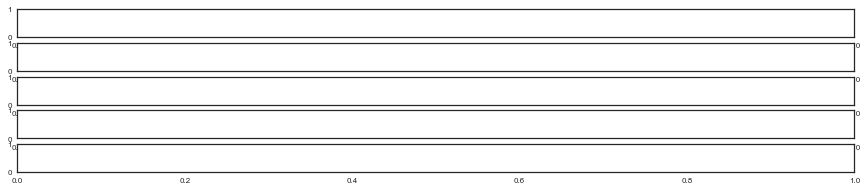

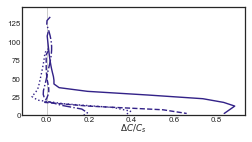

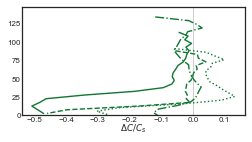

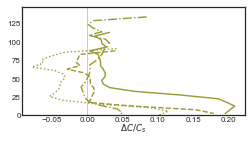

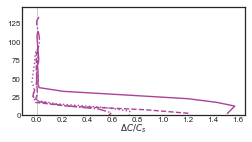

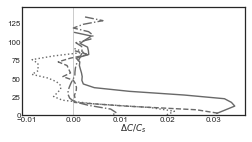

In [19]:
sns.set_style('white')
sns.set_context('paper')
fig, ax =plt.subplots(5,1,figsize=(15,3))

for color, key, lab, Csb in zip(colours[:],tracers[:], labels_tra[:],sb_conc_A[:]):
    fig,ax = plt.subplots(1,1,figsize=(4,2))
    plot_profiles_advPh(ax, ptr_fileA, maskCA, ptr_fileANoC,maskCANoC, key, color, Csb,linestyles,
                        st_names,zslice,tslice, ZA, yindA, xindA, sb_Ast, -DepthA, min_dC=-20)
    


### Plots for talks

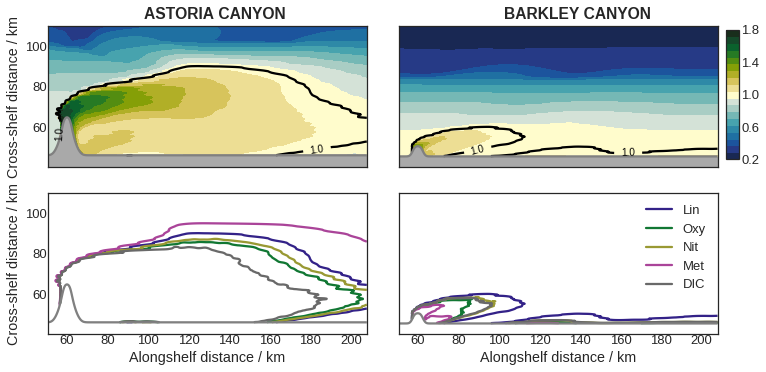

In [13]:
sns.set_style('white')
sns.set_context('talk')
fig=plt.figure(figsize=(12,6))
#plt.rcParams.update({'font.size': 14})
gs = gspec.GridSpec(2, 2, hspace=0.05,wspace=0.1)

ax0 = plt.subplot(gs[0,0])
 
ax4 = plt.subplot(gs[0,1])

ax8 = plt.subplot(gs[1,0])

ax12 = plt.subplot(gs[1,1])

yslice_pl = slice(110,360)
xslice_pl = slice(120,500)
tslice = slice(8,nt)
key = 'Tr01'

# Bottom concetration linear profile (mean during adv. phase)
ax0, mesh0 = PlotPoolsTr(ax0, tslice, key, ptr_fileA, 
                  xslice_pl, yslice_pl, nz,
                  hFacA, rAA, DepthA, XA, YA,sb_Ast,
                  sbdepthA=sb_depthA)
ax0.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],[-sb_depthA], colors='0.5')

ax4, mesh4 = PlotPoolsTr(ax4, tslice, key, ptr_fileB, 
                         xslice_pl, yslice_pl, nz,
                         hFacB, rAB, DepthB, XB, YB,sb_Bar,
                         sbdepthA=sb_depthB)
ax4.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],[-sb_depthB], colors='0.5')
ax4.yaxis.set_ticks([])
ax0.set_ylabel('Cross-shelf distance / km')
ax0.xaxis.set_ticks([])
ax4.xaxis.set_ticks([])

cbar_ax = fig.add_axes([0.91, 0.55, 0.015, 0.3])
cb=fig.colorbar(mesh4, cax=cbar_ax,ticks=[0.2,0.6,1.0,1.4,1.8],format='%1.1f')
cb.ax.yaxis.set_tick_params(pad=2)

zslice = slice(0,30)
zsliceB = slice(0,50)
unit = units[0]


# Pool boundary all tracers (mean during adv. phase)
proxy = []
for key, color, lab in zip(tracers[:], colours[:], labels_tra[:]):
    ax8 = PlotPoolBoundary(ax8, tslice, key, ptr_fileA, 
                           xslice_pl, yslice_pl, nz,
                           hFacA, rAA, DepthA, XA, YA,sb_Ast,color,
                           sbdepthA=sb_depthA)

    ax12 = PlotPoolBoundary(ax12, tslice, key, ptr_fileB, 
                           xslice_pl, yslice_pl, nz,
                           hFacB, rAB, DepthB, XB, YB,sb_Bar,color,
                           sbdepthA=sb_depthB)
    
    line = mlines.Line2D([], [], color=color, label=lab)
    proxy.append(line)

ax8.contour(XA[xslice_pl]/1000, YA[yslice_pl]/1000, DepthA[yslice_pl,xslice_pl],[-sb_depthA], colors='0.5')
ax12.contour(XB[xslice_pl]/1000, YB[yslice_pl]/1000, DepthB[yslice_pl,xslice_pl],[-sb_depthB], colors='0.5')
ax12.legend(handles=proxy)
ax12.yaxis.set_ticks([])
ax8.set_ylabel('Cross-shelf distance / km')
ax8.set_xlabel('Alongshelf distance / km')
ax12.set_xlabel('Alongshelf distance / km')

ax0.text(0.3,1.05,'ASTORIA CANYON',fontweight='bold',transform=ax0.transAxes)
ax4.text(0.33,1.05,'BARKLEY CANYON',fontweight='bold',transform=ax4.transAxes)

plt.savefig('pool_boundary_defence.eps',format='eps', bbox_inches='tight')